# PyTorch and CNNs

This week we covered the basics of how convolutional neural networks work at the theoretical level in the [CNN Crash Course (U-M Only)](https://docs.google.com/presentation/d/1p3EWFMfTNT773PEt3q16tlLxQ4FuD-JTwnTj1A_N4a0/edit?usp=sharing). This notebook will cover how we can **implement** CNNs in Python using the PyTorch Library. There will be two parts to this tutorial:

⚠️ **Note**: This tutorial will make reference to concepts from object-oriented programming (OOP) such as inheritance, encapsulation, and abstraction.

## Intro to PyTorch

[PyTorch](https://pytorch.org/tutorials/) is a leading open-source deep learning framework developed by Meta AI. It's favored by researchers and developers across various machine learning domains, including image recognition, NLP, and reinforcement learning, thanks to its flexibility and ease of use. Its dynamic nature allows for agile experimentation and debugging, catering to both beginners and experts in deep learning.

If you would like to work through a more principled tutorial for PyTorch, we recommend looking through the official PyTorch tutorial series (either on the [docs](https://pytorch.org/tutorials/beginner/basics/intro.html) or on [YouTube](https://www.youtube.com/playlist?list=PL_lsbAsL_o2CTlGHgMxNrKhzP97BaG9ZN))! As always, ask us if you have any questions about any of the content covered (this is why we're here)!

To get started with using PyTorch, you will need to import the package (which the cell below will do for us).

In [7]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Loading Training and Testing Data

A core component of machine learning is using data to train models and learn the patterns in the dataset. To enable fast and scalable dataset loading, PyTorch defines two major objects for loading data from file:
- `Dataset` ([docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)) represents a collection of data to use in training deep learning models. At their surface, `Dataset` looks similar to a Python list, but can be customized extensively for better performance.
- `DataLoader` ([docs](https://pytorch.org/docs/stable/data.html?highlight=data+loader#torch.utils.data.DataLoader)) prepares data into batches for training neural networks (using mini-batch stochastic gradient descent), wrapping an input Dataset object. `DataLoader` also offers parallelization methods that make training faster.
  - If you want to learn more about mini-batch SGD, check out [this](https://www.deeplearningbook.org/contents/optimization.html) resource on general deep learning training or [this](https://developers.google.com/machine-learning/crash-course/reducing-loss/stochastic-gradient-descent) more beginner-friendly descriptor,

In the example below, we use the datasets module to create two data loaders - one for the training set and one for the testing set. In this case, we are using the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, consisting of images of handwritten digits.

In [ ]:
train_data = datasets.MNIST(
    root="private",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="private",
    train=False,
    download=True,
    transform=ToTensor()
)

Later on in this project, we will actually create a _custom_ dataset to load our dataset efficiently! We'll leave that discussion for later however.

In the cell below, we use the bracket operator (`[]`) to iterate through a dataset (like a Python list) and display the sizes of the images in this dataset and their corresponding label (the number that was written).

Image 0 has shape torch.Size([1, 28, 28]), corresponding to digit 5
Image 1 has shape torch.Size([1, 28, 28]), corresponding to digit 0
Image 2 has shape torch.Size([1, 28, 28]), corresponding to digit 4
Image 3 has shape torch.Size([1, 28, 28]), corresponding to digit 1
Image 4 has shape torch.Size([1, 28, 28]), corresponding to digit 9


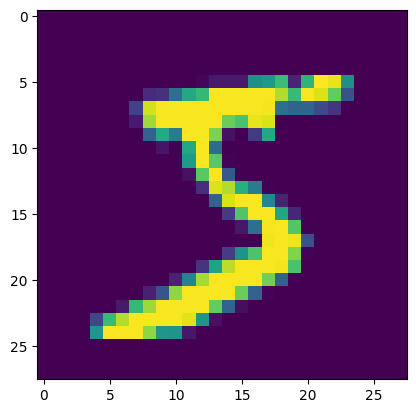

In [4]:
index = 0
for image, label in train_data:
    print(f"Image {index} has shape {image.shape}, corresponding to digit {label}")
    index += 1
    if index == 5:
        break
plt.imshow(train_data[0][0].view(-1,28)) # have to do some reshaping to visualize the image properly

**Checkpoint**: 
1. Read through the [docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for `Dataset` and do some research on your own - can you find the number of images in `train_data`?
2. Use `seaborn` (think back to the MDST tutorial checkpoints) to plot a bar plot of the frequency of each label in the training dataset. Do all labels have the same number of associated images?
3. Create a `DataLoader` that wraps the `train_data` dataset. This data loader should return images in batches of 32, using 2 workers, and have shuffle enabled. You might the [docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) helpful here.

In [ ]:
# Write your solution here!

## Defining Convolutional Neural Networks

### Mapping Convolution Layers to PyTorch

Recall that we can think of a convolutional neural network (CNN) of having two parts:
1. a **feature extraction** step that convert an input image to a vector representing the image
2. a **predictor** that takes the image and converts it to a vector of preductions

We will discuss how to initialize the different layers associated with each component in PyTorch. All classes used are from the `torch.nn` ([docs](https://pytorch.org/docs/stable/nn.html#module-torch.nn)) submodule.

#### Feature Extraction

A **convolutional layer** performs convolution over the input images to search for patterns and record where the filter patterns match the input.
- **Input**: Tensor from previous layer $(D \times H \times W)$
- **Process**: Convolutional layers include $K$ filters, and convolution is performed for each of the $K$ filters!
- **Output**: Output tensor from convolving each filter over the input image $(K \times H’ \times W’)$

In PyTorch, a convolution layer can be created as:
```py
conv_layer = torch.nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=3)
```

To break down each parameter:
- `in_channels`  = $D$, the number of input channels (depth) - remember that images are 3D!
- `out_channels` = $k$, the number of output channels. **KEY**: this is equal to the number of filters stored in this convolution layer.
- `kernel_size` is the size of the filter (which is also called a _kernel_) in pixels. We assume here that the filter is square (which is most common in practice). Above, we set the kernel size to 3 pixels (also another common setting for kernel sizes)
- `stride` is how far we move the window every time we compare the filter to the underlying image at that point

A **activation layer** applies an activation function (like [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)) to the input tensor.
- **Input**: Tensor from previous layer $(D x H x W)$
- **Process**: Apply a ✨ nifty ✨ function to each number in tensor
- **Output**: Output tensor after activation $(D x H x W)$

In PyTorch, an activation layer for the ReLU activation function can be created as
```py
relu = torch.nn.ReLU()
```
You can see other available activation functions [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity); however ReLU is one of the most common in practice.

A **pooling layer** downsamples the input image to make the tensor smaller. Reducing information increases computation speed and removes noise from the input image, improving generalization. 
- **Input**: Tensor from previous layer $(D \times H \times W)$
- **Process**: Pool the input to make it smaller.
- **Output**: Output tensor from convolving each filter over the input image $(D \times H’ \times W’)$

In PyTorch, a max pooling layer can be created as:
```py
pool_layer = torch.nn.MaxPool2D(kernel_size=2, stride=2)
```

To break down each parameter:
- `kernel_size` is the size of the pooling window We assume here that the filter is square (which is most common in practice). Above, we set the filter size to 2 pixels, which is standard for pooling layers.
- `stride` is how far we move the window when downsampling the input. Above, we set the stride to 2 pixels, whcih is also standard for pooling layers.

You can see other available pooling methods (aside from max pooling) [here](https://pytorch.org/docs/stable/nn.html#pooling-layers).

A **flatten layer** flattens the 3D tensor input into a single dimensional vector
- **Input**: Tensor from previous layer $(D x H x W)$
- **Process**: Flatten 3D tensor input into vector in order of inner most dimension (flattens width first, then height, then depth).
- **Output**: Output vector after activation $(DHW)$

In PyTorch, a flatter layer can be created as
```py
relu = torch.nn.flatten()
```

### Create a Model Definition.

In PyTorch, `nn.Module` is a base class used to define machine learning models! Using object-oriented programming, this class allows us to define the exact architecture for a model (such as a convolutional neural network) _while_ encapsulating and abstracting away shared behavior such how to _train_ models like convolutional neural networks.

Below is an example of a class definition in Python for a very simple convolutional neural network called `BasicCNN`. If you haven't seen class definitions before in Python, consider reading through [this blog post](https://realpython.com/python-classes/).



In [12]:
class BasicCNN(nn.Module): # Net inherits from nn.Module
    def __init__(self):
        """Constructor for the neural network."""
        super(BasicCNN, self).__init__()        # Call superclass constructor
        self.fc1 = nn.Linear(28 * 28, 128) # Create fully connected layer as an instance variable of Net 
        self.fc2 = nn.Linear(128, 10)      # Create another fully connected layer. Output = 10 for 10 classes
        self.relu = nn.ReLU()              # Activation function for this neural network
        self.flatten = nn.Flatten()        # Convert image to flat array

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x) # call the layers like functors to process inputs
        x = self.relu(x) 
        x = self.fc2(x)
        x = self.relu(x)
        return x

There is a lot of dense code in that block above, so let's break it down. We'll start by covering the fundamental _requirements_ for this class to be a valid PyTorch model:
1. `Net` must inherit from `nn.Module` and call the superclass constructor using `super(Net, self).__init__()`
2. Define all the relevant layers in the constructor (`__init__`()`) for your model.
3. Override the `forward` function and specify how to get predicted labels for some input

#### Subclass Inheritance

This first criteria is met by defining the subclass relationship between `Net` and `nn.Module`
- When we write the first line of the class defintion, we write `Net(nn.Module):` to indicate that `Net` is a subclass of `nn.Module`
- On line 4, we call the superclass constructor for this model

The third criteria is more tricky - we have to define a function called `forward()` that specifies _how_ to make predictions for some input data. For the model above, we have the following definition for this function

```py
def forward(self, x):
    x = self.flatten(x)
    x = self.fc1(x) # call the layers like functors to process inputs
    x = self.relu(x) 
    x = self.fc2(x)
    x = self.relu(x)
    return x
```

Let's break down each line of this function:
1. The function takes as input the parameters
   1. `self` - is the self-pointer, is equivalent to `this` in C++
   2. `x` - the input to the model. You can think of this as a list or an image
2. Take the input and pass it through `self.fc1(x)`. This is a member variable corresponding to a **dense** (or [linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)) layer. This is a component of a neural network that takes in a vector (list of numbers) and maps it to another vector.
   1. Note that we treat these variables like **functors** - we can call them as if they were functions rather than objects
3. We take the output of the previous dense layer and apply the [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) activation function
4. The input is passed it through `self.fc2(x)`, the second dense layer. This corresponds to another transformation of the of the output of `self.fc1()`
5. The output of the previous dense layer is transformed using the ReLU activation function 
6. We return the final transformed value of `x`. This will then be used later down the line to convert the vector to a predicted label.

**Checkpoint** Use the [documentation](https://pytorch.org/docs/stable/nn.html) for all possible layers that could be used and follow the advice from  

## Training Neural Networks

To train any neural network, you need to specify the:
- loss function - in PyTorch, we can use Cross-Entropy Loss via `nn.CrossEntropyLoss`
- optimizer - algorithm for training model. We will use stochastic gradient descent (technically mini-batch SGD) via `torch.optim.SGD`

In [ ]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.007) # lr is the learning rate

To train the model, we use the following training loop - it is fairly common across PyTorch to use a similar training loop

In [ ]:
epochs = 20 # Number of epochs to train for
losses, accuracies = [], []

for epoch in range(epochs):
    model.train()

    for X, y in train_loader:
        optimizer.zero_grad()        # reset gradients
        outputs = model(X)           # make a prediction using the model
        loss = criterion(outputs, y) # compare predictions to ground truth labels
        loss.backward()              # calculate gradients
        optimizer.step()             # update parameters

    losses.append(loss.detach().item())

    model.eval()
    with torch.no_grad():
        # test performance after each epoch
        correct, total = 0, 0
        for X, y in test_loader:
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1) # get predicted digit
            total += len(y)
            correct += (predicted == y).sum().item()
        print(
            f"Epoch [{epoch+1}/{epochs}], Recent Loss: {loss.item():.4f}, Accuracy: {correct / total *100:.2f}%"
        )
        accuracies.append(correct / total)

We can visualize the training loss and test accuracy of our neural network change as the model trains:

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss by Epoch")
plt.title("Training Loss")
plt.show()

**Checkpoint**: Use `plt.plot` and `accuracies` to visualize the test accuracy of the model as it trains

In [ ]:
# TODO: Visualize the test accuracy of model as it trains

## Model Testing

Let's test our model on the entire testing dataset now we're done training!

In [ ]:
model.eval()
with torch.no_grad():
    # test performance after each epoch
    correct, total = 0, 0
    for image, label in test_data:
        outputs = model(image.view(1, 1, 28, 28))
        _, predicted = torch.max(outputs.data, 1)  # get predicted digit
        total += 1
        correct += (predicted.item() == label)
    print(f"Accuracy: {correct / total *100:.2f}%")

Let's see some examples - consider the 5th image in the testing dataset. Our model predicts it to be the digit `4` - not bad!

In [ ]:
image3 = test_data[4][0]
plt.imshow(image3.view(-1, 28))
print(f"Predicted label: {model(image3).argmax()}, Actual label: {test_data[4][1]}")

Now consider the 2nd image in the testing dataset. Our model predicts it to be the digit `6`, when its actually `5`! It seems we have some more training to do ...

In [ ]:
image3 = test_data[8][0]
plt.imshow(image3.view(-1, 28))
print(f"Predicted label: {model(image3).argmax()}, Actual label: {test_data[8][1]}")

That's it! You've trained a model using PyTorch from scratch to be pretty good at classifying this dataset. Next week, we'll practice using **convolutional neural networks**!